In [3]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import ast
import json
import operator
import seaborn as sn

PREPROCESSED_CLASSES = ['BitTorrent', 'Cridex', 'FTP', 'Geodo', 'Gmail', 'Htbot', 'Miuref', 'Neris', 'Nsis-ay', 'Outlook', 'SMB', 'Virut', 'Weibo', 'WorldOfWarcraft']
PREPROCESSED_CLASSES_NERIS_VIRUT = ['BitTorrent', 'Cridex', 'FTP', 'Geodo', 'Gmail', 'Htbot', 'Miuref', 'Neris/Virut', 'Nsis-ay', 'Outlook', 'SMB', 'Weibo', 'WorldOfWarcraft']

PAYLOAD_CLASSES = ['BitTorrent', 'Cridex', 'FTP', 'Gmail', 'Htbot', 'Neris', 'Nsis-ay', 'Outlook', 'SMB', 'Shifu', 'Virut', 'Weibo']
PAYLOAD_CLASSES_NERIS_VIRUT = ['BitTorrent', 'Cridex', 'FTP', 'Gmail', 'Htbot', 'Neris/Virut', 'Nsis-ay', 'Outlook', 'SMB', 'Shifu', 'Weibo']

# Standard plots for one training task (model dataset combination)

In [28]:
csv_files = ["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/vgg-19/fc/scores1.csv"] #Insert files in this list (files need to be in order of training --> first hyperparameter opt.)

train_losses = []
val_losses = []
val_accuracies = []
val_f1 = []
val_kappa = []


for file in csv_files:
    if file.endswith(".csv"):
        df = pd.read_csv(file)
        # Training loss will be tracked during the whole training process
        train_losses += df["training-losses"].to_list()

        val_losses += df["loss"].to_list()
        val_accuracies += df["accuracy"].to_list()
        val_f1 += df["macro-f1"].to_list()
        val_kappa += df["kappa"].to_list()
        
n_val_epochs = len(val_losses)
val_epochs = range(1, n_val_epochs+1)
# since we save multiple train losses per epoch our csv contains list strings 
train_losses = [ast.literal_eval(t) for t in train_losses]
# we only want to print the train loss at the end of the epoch
train_losses = [sublist[-1] for sublist in train_losses]
n_train_epochs = len(train_losses)
train_epochs = range(1, n_train_epochs+1)
plt.figure(figsize=(n_train_epochs/4, 8))
plt.plot(train_epochs, train_losses, marker='x', label="Training Set")
plt.plot(val_epochs, val_losses, marker='x', label="Validation Set")
plt.xticks(val_epochs)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("val_train_loss.svg", format="svg")

plt.clf()

plt.figure(figsize=(n_val_epochs/4, 8))
plt.plot(val_epochs, val_accuracies, label = "accuracy", marker='x')
plt.plot(val_epochs, val_f1, label = "macro-f1", marker='*')
plt.plot(val_epochs, val_kappa, label = "kappa", marker="o")
plt.xlabel("Epoch")
plt.xticks(val_epochs)
plt.ylabel("Scores from 0 to 1")
plt.legend()
plt.savefig("val_scores.svg", format="svg")

plt.clf()


<Figure size 350x800 with 0 Axes>

<Figure size 350x800 with 0 Axes>

# Accuracy and F1-Comparison

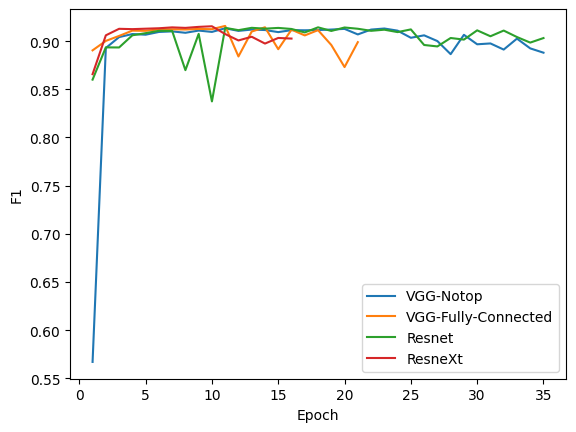

In [29]:
csv_files = ["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/vgg-19/notop_nerisvirut/scores1.csv", "/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/vgg-19/fc_nerisvirut/scores1.csv", "/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/resnet-50/resnet_virutneris/scores1.csv", "/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/resnet-50/resneXt_virutneris/scores1.csv"]

models = ["VGG-Notop", "VGG-Fully-Connected", "Resnet", "ResneXt"]

accuracies_per_model = []
f1_per_model = []

for file in csv_files:
    if file.endswith(".csv"):
        df = pd.read_csv(file)
        # Training loss will be tracked during the whole training process
        accuracies_per_model.append(df["accuracy"].to_list())
        f1_per_model.append(df["macro-f1"].to_list())

        
for j, model in enumerate(models):
    accuracies = [100* acc for acc in accuracies_per_model[j]]
    epochs = range(1, len(accuracies)+1)
    plt.plot(epochs, accuracies, label=model)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy_comparison.svg", format="SVG")
plt.clf()

for j, model in enumerate(models):
    f1 = f1_per_model[j]
    epochs = range(1, len(f1)+1)
    plt.plot(epochs, f1, label=model)

plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.savefig("F1_comparison.svg", format="SVG")

# ROC Curve

In [ ]:
roc = torch.load("/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/notop/roc.pt")
fpr = roc[0]
tpr = roc[1]
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(fpr))))
for label in range(len(fpr)):
    fpr_label = fpr[label].tolist()
    tpr_label = tpr[label].tolist()
    plt.plot(fpr_label, tpr_label, color = next(color), label = "class " + str(label))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.savefig("ROC.svg", format="svg")
plt.clf()

# Histogram of prediction distribution

In [ ]:
distribution_json = '/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/notop/bonus_scores.json'

with open(distribution_json, 'r') as f:
  distribution_dict = json.load(f)["Label_prediction_distribution"]
multiclass = True 


if multiclass:
    probability_true_label = []
    probability_other = []
    for label in distribution_dict.keys():
        predictions_label = distribution_dict[label]
        total_instances_label = len(predictions_label)
        for prediction in predictions_label:
            true_prediction = prediction[int(label)]
            probability_true_label.append(true_prediction)
            probability_other.append(1 - true_prediction)
        
        # calculate interquartile range for Freedman-Diaconis number of bins
        probability_true_label.sort()
        probability_other.sort()
        
        q3, q1 = np.percentile(probability_true_label, [75 ,25])
        iqr = q3 - q1
        bin_width = 2 * (q3 - q1) * np.cbrt(total_instances_label)
        n_bins = round((max(probability_true_label) - min(probability_true_label)) / bin_width)
        
        plt.hist(probability_true_label, bins=n_bins, label="true_class", log=True)
        #plt.hist(probability_other, bins=n_bins, label="other_classes", log=True)
        plt.ylabel('Frequency of prediction')
        plt.xlabel('Predicted Probability by Model')
        plt.legend()
        plt.savefig("histogram_class" + label + ".svg", format="svg")
        plt.clf()


In [ ]:
# Barchart most frequently mistaken classes

In [ ]:
mistakes_json = '/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/notop/bonus_scores.json'

with open(mistakes_json, 'r') as f:
  mistakes = json.load(f)["Wrong_prediction_classes"]

count_per_combination = {}
for mistake in mistakes:
  mistake_sorted = list(mistake)
  mistake_sorted.sort()
  mistake_sorted = tuple(mistake_sorted)
  if mistake_sorted in count_per_combination.keys():
    count_per_combination[mistake_sorted] += 1
  else:
    count_per_combination[mistake_sorted] = 1

top5_keys = sorted(count_per_combination, key=count_per_combination.get, reverse=True)[:5]
top5_values = [count_per_combination[key] for key in top5_keys]
top5_keys = [str(key) for key in top5_keys]
plt.bar(top5_keys, top5_values, align='center', alpha=0.5)
plt.xlabel('mistaken classes')
plt.ylabel('occurance of mistake')
plt.savefig("frequent_mistakes.svg", format="svg")
plt.clf()




# Confusion Matrix

{'BitTorrent': 0.0, 'Cridex': 0.0008130081300813008, 'FTP': 0.0010672358591248667, 'Gmail': 0.0, 'Htbot': 0.0425531914893617, 'Neris': 0.20863309352517986, 'Nsis-ay': 0.05185185185185185, 'Outlook': 0.30817217716781037, 'SMB': 0.00043038519474930065, 'Shifu': 0.0, 'Virut': 0.20127118644067796, 'Weibo': 0.0001675603217158177}
{'BitTorrent': 0.0, 'Cridex': 0.0008130081300813385, 'FTP': 0.0010672358591248265, 'Gmail': 0.0, 'Htbot': 0.04255319148936165, 'Neris': 0.2086330935251799, 'Nsis-ay': 0.051851851851851816, 'Outlook': 0.3081721771678103, 'SMB': 0.00043038519474924986, 'Shifu': 0.0, 'Virut': 0.20127118644067798, 'Weibo': 0.00016756032171583168}


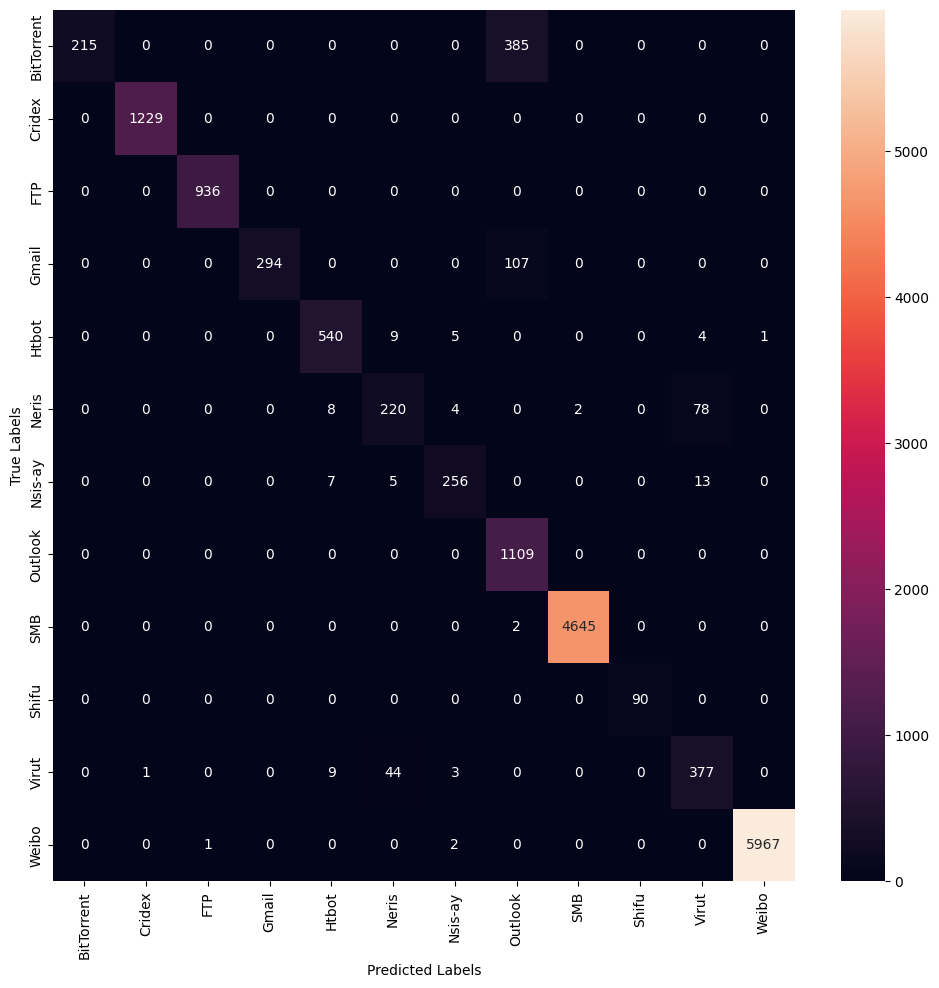

In [25]:
FDR_per_class = {}
FDR2_per_class = {}
cf_matrix = torch.load("/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/vgg-19/fc/confusion_matrix.pt")
cf_matrix = cf_matrix.numpy()
df_cm = pd.DataFrame(cf_matrix,
                    columns = [i for i in PAYLOAD_CLASSES],
                    index=[i for i in PAYLOAD_CLASSES])

for class_idx, class_name in enumerate(df_cm.columns):
    class_predictions = df_cm[class_name]
    class_predictions = class_predictions.to_list()
    TP = class_predictions[class_idx]
    false_predictions = class_predictions[:class_idx] + class_predictions[class_idx+1:]
    FP =  np.sum(false_predictions)
    FDR = FP / (TP + FP)
    FDR2_per_class[class_name] = 1 - (TP / (TP+FP))
    FDR_per_class[class_name] = FDR

print(FDR_per_class)
print(FDR2_per_class)
plt.figure(figsize=(10,10))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.savefig("Confusion.svg", format="svg", dpi = 400)

# Scores to class

In [23]:
F1_per_label = [0.5276073619631901, 0.9995933306222042, 0.999466097170315, 0.8460431654676259, 0.9617097061442564, 0.7457627118644068, 0.9292196007259528, 0.8178466076696166, 0.9995696148052508, 1.0, 0.8322295805739514, 0.9996649355000837]
Recall_per_label = [0.35833333333333334, 1.0, 1.0, 0.7331670822942643, 0.9660107334525939, 0.7051282051282052, 0.9110320284697508, 1.0, 0.9995696148052508, 1.0, 0.868663594470046, 0.9994974874371859]
Precision_per_label = [1.0, 0.9991869918699187, 0.9989327641408752, 1.0, 0.9574468085106383, 0.7913669064748201, 0.9481481481481482, 0.6918278228321897, 0.9995696148052508, 1.0, 0.798728813559322, 0.9998324396782842]
print(list(zip(PAYLOAD_CLASSES, F1_per_label)))
print(list(zip(PAYLOAD_CLASSES, Recall_per_label)))
print(list(zip(PAYLOAD_CLASSES, Precision_per_label)))

[('BitTorrent', 0.5276073619631901), ('Cridex', 0.9995933306222042), ('FTP', 0.999466097170315), ('Gmail', 0.8460431654676259), ('Htbot', 0.9617097061442564), ('Neris', 0.7457627118644068), ('Nsis-ay', 0.9292196007259528), ('Outlook', 0.8178466076696166), ('SMB', 0.9995696148052508), ('Shifu', 1.0), ('Virut', 0.8322295805739514), ('Weibo', 0.9996649355000837)]
[('BitTorrent', 0.35833333333333334), ('Cridex', 1.0), ('FTP', 1.0), ('Gmail', 0.7331670822942643), ('Htbot', 0.9660107334525939), ('Neris', 0.7051282051282052), ('Nsis-ay', 0.9110320284697508), ('Outlook', 1.0), ('SMB', 0.9995696148052508), ('Shifu', 1.0), ('Virut', 0.868663594470046), ('Weibo', 0.9994974874371859)]
[('BitTorrent', 1.0), ('Cridex', 0.9991869918699187), ('FTP', 0.9989327641408752), ('Gmail', 1.0), ('Htbot', 0.9574468085106383), ('Neris', 0.7913669064748201), ('Nsis-ay', 0.9481481481481482), ('Outlook', 0.6918278228321897), ('SMB', 0.9995696148052508), ('Shifu', 1.0), ('Virut', 0.798728813559322), ('Weibo', 0.9998